In [37]:
%pylab inline
from astropy.table import Table   #astropy routine for reading tables
import pandas   # we'll mostly work with things in Pandas

# Random forest routine from scikit-learn:
from sklearn.ensemble import RandomForestRegressor

# kNN routine from scikit-learn:
from sklearn.neighbors import KNeighborsRegressor

# Cross-Validation routines:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

Populating the interactive namespace from numpy and matplotlib


## Reading in the data

In [38]:
#read in catalog of magnitudes and redshifts
# CHANGE PATH VARIABLE TO POINT TO DIRECTORY WITH THE FILE
path='./'

# easiest way to read in a FITS BINTABLE file containing a database is
# using astropy
cat = Table.read(path+'data_trim.fits.gz')

# we then convert the catalog to Pandas form
cat=cat.to_pandas()


# How big is the catalog?
print('Full catalog: ',len(cat),' objects')

# What information does it contain for each object?
print(cat.columns)


Full catalog:  8508  objects
Index(['U', 'G', 'R', 'I', 'Z', 'Y', 'UERR', 'GERR', 'RERR', 'IERR', 'ZERR',
       'YERR', 'RADIUS_ARCSEC', 'ZHELIO', 'MAGB', 'UB_0'],
      dtype='object')


## Setting up a workhorse function to plot photometric redshift estimates vs. true (spectroscopic) redshifts

In [39]:
#This is a function that makes a plot of photometric redshift 
#    as a function of spectroscopic redshift 
#    and calculates key statistics.  It will save us a lot of work.
def plot_and_stats(zspec,zphot):
    
    x = np.arange(0,5.4,0.05)

# define differences of >0.15*(1+z) as non-Gaussian 'outliers'    
    outlier_upper = x + 0.15*(1+x)
    outlier_lower = x - 0.15*(1+x)

    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15
    notmask = ~mask 
    
#Standard Deviation of the predicted redshifts compared to the data:
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)

#Normalized MAD (Median Absolute Deviation):
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))

#Percentage of delta-z > 0.15(1+z) outliers:
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    
    #Median offset (normalized by (1+z); i.e., bias:
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    
    # make photo-z/spec-z plot
    plt.figure(figsize=(8, 8))
    
    #add lines to indicate outliers
    plt.plot(x, outlier_upper, 'k--')
    plt.plot(x, outlier_lower, 'k--')
    plt.plot(z_spec[mask], z_phot[mask], 'r.', markersize=6,  alpha=0.5)
    plt.plot(z_spec[notmask], z_phot[notmask], 'b.',  markersize=6, alpha=0.5)
    plt.plot(x, x, linewidth=1.5, color = 'red')
    plt.title('$\sigma_\mathrm{NMAD} \ = $%6.4f\n'%nmad+'$(\Delta z)>0.15(1+z) $ outliers = %6.3f'%(eta*100)+'%', fontsize=18)
    plt.xlim([0.0, 2])
    plt.ylim([0.0, 2])
    plt.xlabel('$z_{\mathrm{spec}}$', fontsize = 27)
    plt.ylabel('$z_{\mathrm{photo}}$', fontsize = 27)
    plt.grid(alpha = 0.8)
    plt.tick_params(labelsize=15)
    plt.show()
    

## Setting up data arrays in the formats needed by scikit-learn

Scikit-learn uses a set of features (what in data analysis we might call independent variables) packaged as an N_data $\times$ N_features array; e.g., we have 6 features, so this will be an N $\times$ 6 array.

The dependent variable (i.e., the quantity we want to make an algorithm to predict) will just be an n-element array.

In [40]:
# create convenience arrays for all magnitudes
u_mag = cat.U
g_mag = cat.G
r_mag = cat.R
i_mag = cat.I
z_mag = cat.Z
y_mag = cat.Y

#Redshift array
z = cat.ZHELIO

#vector of redshifts    
data_z = z

# Now, set up input data array for scikit-learn regression algorithms
# We will include galaxy colors (expressed as differences between magnitudes
# in adjoining bands) and one magnitude.
# np.column_stack makes a 2D array out of a set of 1d arrays :
# with 6 variables we get an N x 6 numpy array out
data_colmag = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, 
                               i_mag-z_mag, z_mag-y_mag, i_mag))
data_colmag.shape



(8508, 6)

In [36]:
data_colmag

array([[ 0.25134333,  0.67346123,  0.71327984,  0.46357834,  0.21654871,
        22.76817543],
       [ 0.15768983,  0.43681928,  0.46029589,  0.27916065,  0.41719192,
        22.54181764],
       [-0.0946409 ,  0.67036032,  0.10194948,  0.43562239,  0.2388442 ,
        23.35073131],
       ...,
       [ 1.65654396,  1.40857975,  0.57036954,  0.30304462,  0.14422372,
        21.02016033],
       [ 0.55708075,  0.70100296,  0.2126762 ,  0.23375514, -0.0309323 ,
        21.18117503],
       [ 0.21521262,  0.41043825,  0.49732385,  0.1330247 , -0.02355201,
        21.53967024]])

### Rescaling data

Defining a combined distance between two objects in k-nearest neighbor makes little sense if the different features have very different scales.  The easy way to handle this is to rescale everything to have similar span.  This is often helpful or assumed to have been done for machine learning algorithms.

In `scikit-learn`, most routines follow a standard workflow, and this is no exception:

1) initialize an object of the desired class, which will be used to run the routine.  Parameters that describe how an algorithm will be implemented (e.g., the number of trees in random forest) will generally be set at this point.

2) use the `.fit()` method of the object to set up an algorithm optimized based on our training set

3) Here, use the `.transform()` method to apply a transformation to a dataset; or more commonly, use `.predict()` to use our machine learning algorithm to make predictions for a dataset.

In [41]:
# For k-nearest neighbor we want to rescale all variables 
#    to have mean 0 and variance 1 
# This is often, but not always, important for machine 
#    learning routines
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# the rescaling requires a fit step...
scaler.fit(data_colmag)  

# then we apply the scaler to create a new array of features, 
#   all normalized
scaled_colmag = scaler.transform(data_colmag)

### Initializing our regressor objects

We now set up a random forest regressor and two variants of k-Nearest Neighbor:

In [42]:
# We will set up an implementation of the scikit-learn 
# RandomForestRegressor in an object called 'regrf'. 
regrf = RandomForestRegressor(n_estimators = 50,
                max_depth = 30, max_features = 'auto')


# We need to set up an implementation of the scikit-learn 
# KNeighborsRegressor in an object called 'regrn'. 
# uniformly weighting 10 nearest neighbors:
regknn = KNeighborsRegressor(n_neighbors = 10, weights='uniform')

# or weighting neighbors inversely proportional to their distance:
regknn_d = KNeighborsRegressor(n_neighbors = 10, weights='distance')

# Running photo-z code and testing the results

## Random forest - 50/50 training/test split

First, we'll split our data in two randomly, train with 50%, and test with the other 50%.  

__Evaluate the performance of random forest and kNN from the below code boxes.__  
Activate the calculations for Random Forest and k-Nearest Neighbors in the following code boxes by changing `if 0` to `if 1`.  

__Which algorithm does better at minimizing scatter?  Reducing the fraction of outliers (objects with large deviations)?__

In [44]:
if 1:
    # To better assess the quality of the Random Forest fitting, 
    # we split the data into Training (50%) and Test (50%) sets. 
    # The code below performs this task on the data_mags and data_z arrays:
    
    # 1) randomly divide the sample into 50% training and 50% testing sets  
    # (e.g., data_train, z_train, and scaled_train are the training 
    # portions of data_colmag, data_z, and scaled_colmag
    
    data_train, data_test, z_train, z_test, scaled_train, scaled_test \
            =train_test_split(data_colmag, data_z, scaled_colmag, \
                        test_size = 0.50, train_size = 0.50)

    #Train the regressor using the training data
    regrf.fit(data_train,z_train)

    #Apply the regressor to predict values for the test data
    z_phot = regrf.predict(data_test)
    z_spec = z_test
    
    test_p = z_phot
    test_s = z_spec
    
    z_test,z_spec = [0,0] 
#Make a photo-z/spec-z plot and output summary statistics for the test set.
    plot_and_stats(test_s,test_p)

TypeError: object of type 'int' has no len()

In [46]:
test_p

array([0.6084982 , 0.36099192, 0.57454084, ..., 0.69096972, 0.81382231,
       0.2328059 ])

## k-Nearest neighbors, unweighted, 50-50 split

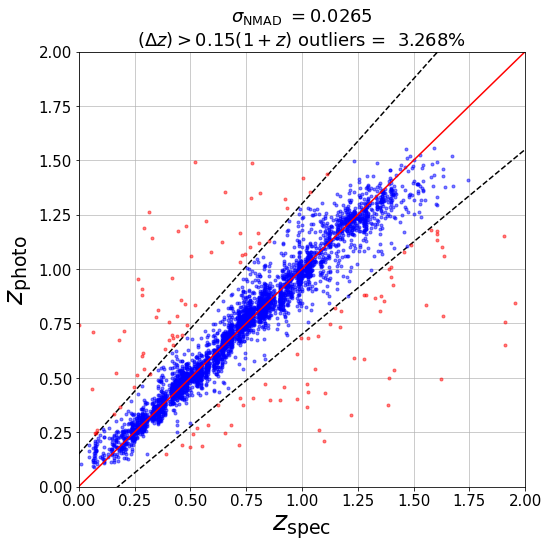

In [11]:
if 1:

    #Train the kNN regressor using the training data
    regknn.fit(scaled_train,z_train)

    #Apply the regressor to predict values for the test data
    z_phot = regknn.predict(scaled_test)
    z_spec = z_test

    #Make a photo-z/spec-z plot and output summary statistics.
    plot_and_stats(z_spec,z_phot)

## k-Nearest neighbors, weighted by distance, 50/50 split

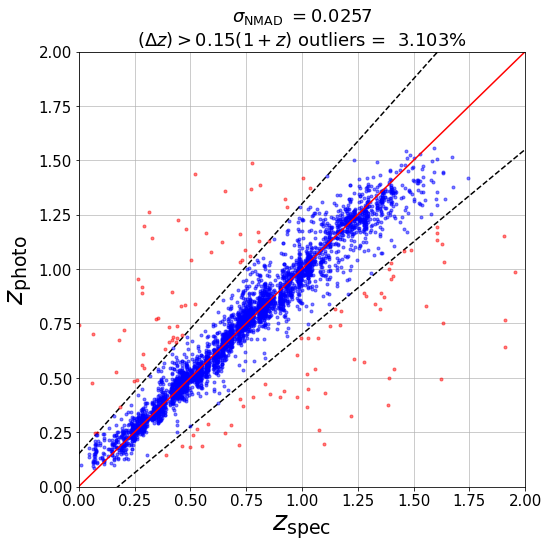

In [19]:
if 1:
    
    #Train the kNN regressor using the training data
    regknn_d.fit(scaled_train,z_train)

    #Apply the regressor to predict values for the test data
    z_phot = regknn_d.predict(scaled_test)
    z_spec = z_test

    #Make a photo-z/spec-z plot and output summary statistics.
    plot_and_stats(z_spec,z_phot)

# Beware: Do not test with the same objects you use to train an algorithm !!!

Let's try it to see why not...
__How do the ztatistics (NMAD + outlier rate) compare when evaluated on the training set, as compared to an independent test set?__

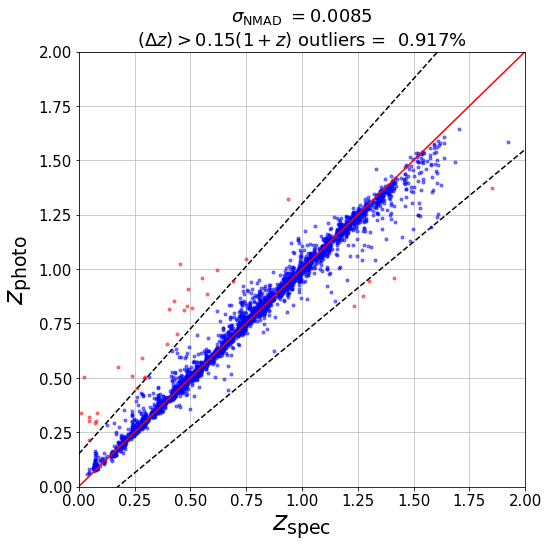

In [17]:
if 1:

    # use the RF regressor trained on the training set, but 
    #   apply it to the training set instead of the test set
    z_phot = regrf.predict(data_train)
    z_spec = z_train

    plot_and_stats(z_spec,z_phot)

# A better way: cross-validation

With a 50-50 training/testing split, we are always training significantly more poorly than we would with the full dataset, and can only use half the data to evaluate how well we are doing.  K-fold cross-validation provides a way around this.  

In k-fold cross-validation, we split the data into k subsets.  We loop over the subsets, training with all but one and testing with the other; in the end, we get the performance of training with a fraction $k-1 \over k$ of the data, but are able to get test statistics based on the __entire__ dataset.

This is easy to do in scikit-learn, but does mean running the training k times on more data than before...so slows things down a lot.

__Compare the performance from random forest regression with 5-fold cross-validation vs. training with only 50% of the sample.__

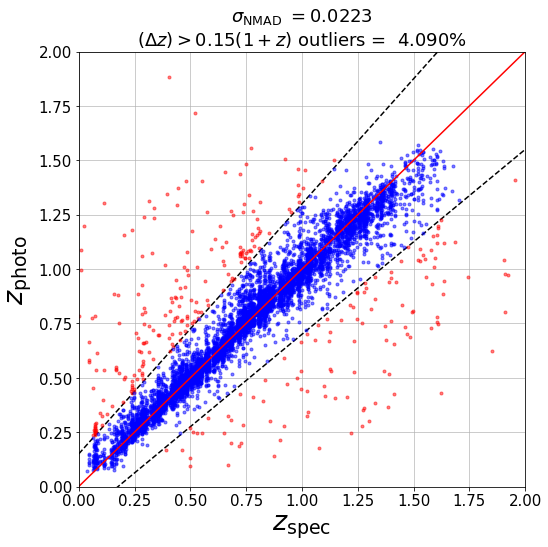

In [20]:
if 1:
    # choose how many parts to split the data into
    n_folds = 5

    # cross_val_predict automatically divides the sample up, 
    #     applies the chosen object to training/testing
    #     on each fold as needed, and results in predictions 
    #     from cross-validation for every entry in the set.
    z_phot = cross_val_predict(regrf, data_colmag,data_z, cv=n_folds)
    z_spec = data_z

    plot_and_stats(z_spec,z_phot)

# What happens when training and test sets are systematically different in their properties?

A major downside to machine learning methods is they tend to extrapolate poorly; i.e., your training set really needs to be representative of the data you will be applying it to.  Below, we try seeing what happens when training and test sets are systematically different (not just differing in random selection).  

__Which of the below causes the worst problems?__

## Test 1: Different magnitude ranges

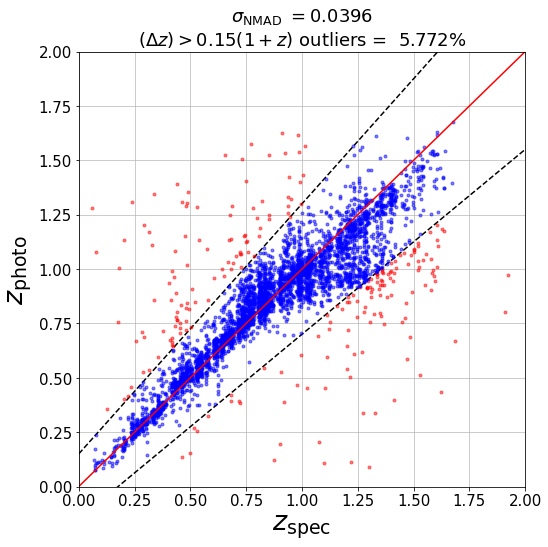

In [21]:
if 1:
    # split the sample at the median magnitude; note that
    #      smaller magnitude means brighter!
    is_bright = r_mag < 23.15

    # we can use a logical statement as a mask to select only
    #       those array elements where it is true
    data_bright = data_colmag[is_bright]
    z_bright = data_z[is_bright]

    # or negate it to select where it is false
    data_faint=data_colmag[~is_bright]
    z_faint = data_z[~is_bright]

    #train the regressor with the bright data
    regrf.fit(data_bright,z_bright)

    # run on the faint test set
    z_phot = regrf.predict(data_faint)
    z_spec = z_faint

    plot_and_stats(z_spec,z_phot)

### or if we run it the opposite way and train on the faint set...

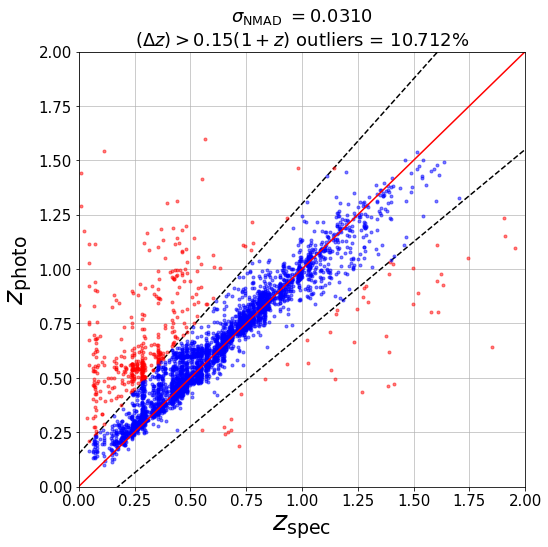

In [22]:
if 1:
    #train the regressor
    regrf.fit(data_faint,z_faint)

    # run on the test set
    z_phot = regrf.predict(data_bright)
    z_spec = z_bright

    plot_and_stats(z_spec,z_phot)

## Test 2: Different colors

Here we split based on color (equivalent to flux ratio between the r and i filters, i.e. red and infrared).

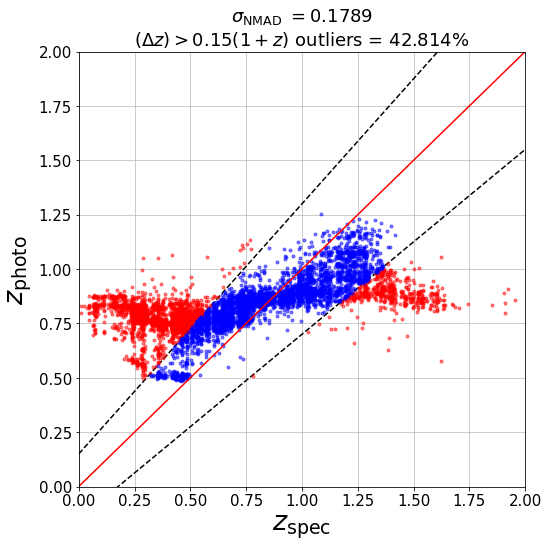

In [23]:
if 1:
    # split the sample based on r-i color.  Remember bigger 
    #      magnitude = fainter, so if r > i,
    #      the object is brighter in the redder band, 
    #      and hence appears redder
    is_red = r_mag - i_mag > 0.8

    data_red = data_colmag[is_red]
    z_red = data_z[is_red]

    data_blue=data_colmag[~is_red]
    z_blue = data_z[~is_red]

    #train the regressor on the red objects
    regrf.fit(data_red,z_red)

    # run on the test set of blue objects
    z_phot = regrf.predict(data_blue)
    z_spec = z_blue

    plot_and_stats(z_spec,z_phot)

## Test 3: Different redshift ranges

Here we split based on redshift -- the quantity we are trying to infer.

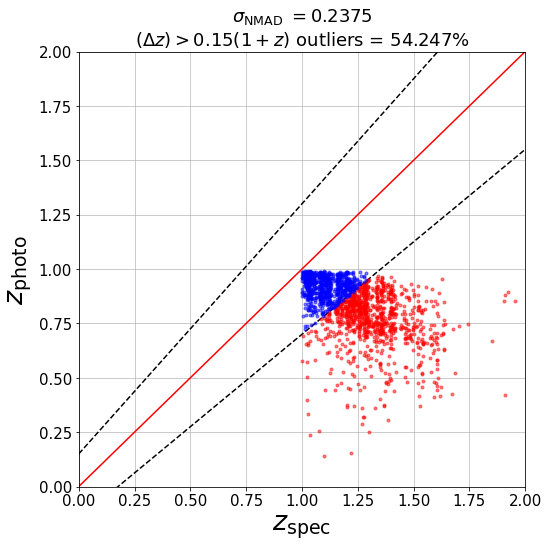

In [25]:
if 1:
    # split the sample based on redshift
    is_hiz = data_z > 1

    data_hiz = data_colmag[is_hiz]
    z_hiz = data_z[is_hiz]

    data_lowz=data_colmag[~is_hiz]
    z_lowz = data_z[~is_hiz]

    #train the regressor
    regrf.fit(data_lowz,z_lowz)

    # run on the test set
    z_phot = regrf.predict(data_hiz)
    z_spec = z_hiz

    plot_and_stats(z_spec,z_phot)

# If you have extra time: 

1) Modify `plot_and_stats()` to add plots of ${z_{phot}-z_{zspec}} \over {1 + z_{spec}}$ as a function of redshift and as a function of $i$ magnitude.  Redo all plots.  What trends do you find in the residuals for each?

2) Look at the documentation for scikit-learn regression routines and try one or two other methods.  Can you do better than the random forest results?  There's a code box below you can work with.

3) Modify `plot_and_stats()` to provide the uncertainty in the standard deviation to help assess whether differences between algorithms are significant. $s (\sigma) = { \sigma \over \sqrt{2N}}$ where $\sigma$ is the standard deviation of the values, $s$ is the uncertainty in that standard deviation, and $N$ is the number of data points.

#  Random Forest for classification

Scikit-learn routines for classification (instead of regression) work pretty similarly, but they output True or False for each prediction, rather than a continuous number.

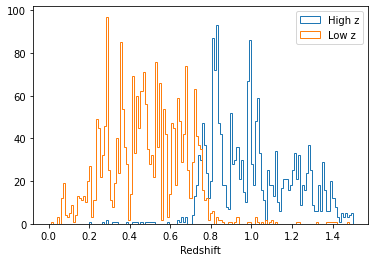

In [26]:
if 1:
    from sklearn.ensemble import RandomForestClassifier

    # set up the classifier object
    classrf = RandomForestClassifier(n_estimators=50)

    # fit a classifier intended to separate objects at
    #       redshift > 0.75 from those at < 0.75
    classrf.fit(data_train,z_train > 0.75)

    # predict the classifications for the test set
    class_predict = classrf.predict(data_test)

    # test which objects are selected as being at high redshift
    ishiz = class_predict == True

    #plot redshift histograms for each sample
    bins = np.linspace(0,1.5,150)
    a,b,c=plt.hist(z_test[ishiz],bins=bins,histtype='step',label = 'High z')
    a,b,c=plt.hist(z_test[~ishiz],bins=bins,histtype='step',label = 'Low z')
    plt.xlabel('Redshift')
    plt.legend()


# If you're curious: Relationships of galaxy properties to redshift

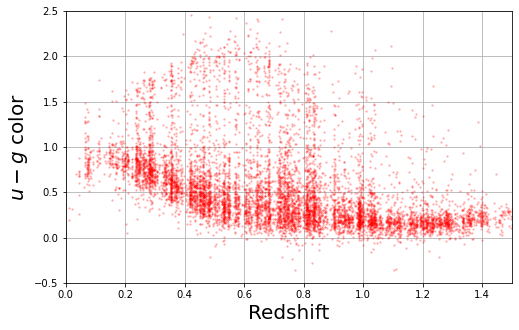

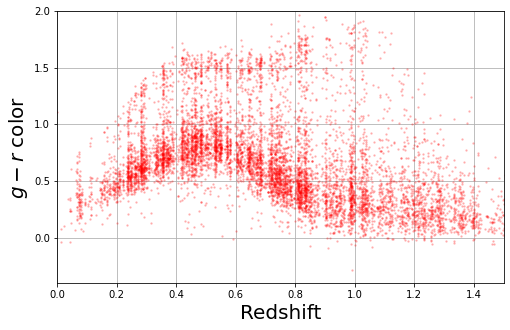

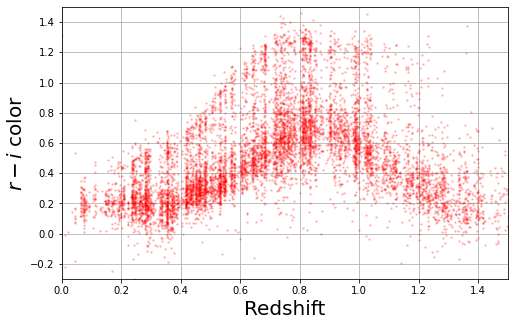

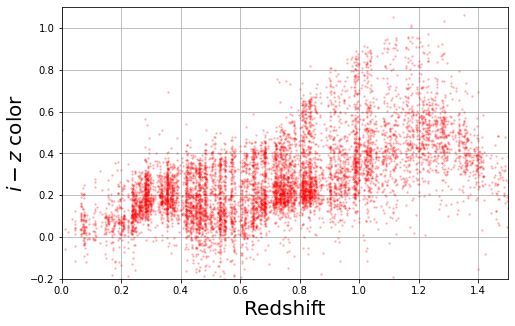

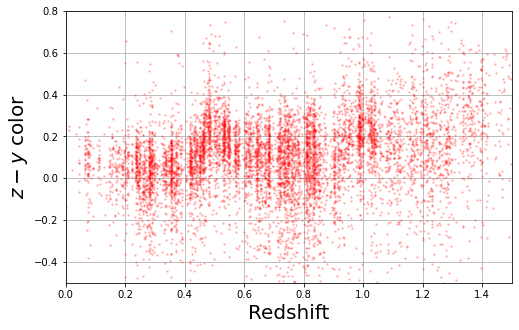

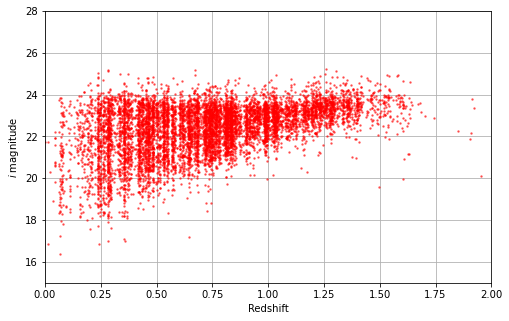

In [27]:
if 1:
# Plots of colors vs. redshift

    plt.figure(figsize=(8, 5))

    plt.plot(z, u_mag-g_mag, '.', color = 'red', markersize=3, alpha=0.2)
    # Axis limits:
    plt.xlim([0., 1.5])
    plt.ylim([-0.5, 2.5])
    #Axis labels
    plt.ylabel('$u-g$ color', fontsize=20)
    plt.xlabel('Redshift',fontsize=20)
    #Add grid lines
    plt.grid()


    plt.figure(figsize=(8, 5))

    plt.plot(z, g_mag-r_mag, '.', color = 'red', markersize=3, alpha=0.2)
    plt.xlim([0., 1.5])
    plt.ylim([-0.4, 2.])
    plt.ylabel('$g-r$ color', fontsize=20)
    plt.xlabel('Redshift',fontsize=20)
    plt.grid()


    plt.figure(figsize=(8, 5))

    plt.plot(z, r_mag-i_mag, '.', color = 'red', markersize=3, alpha=0.2)
    plt.xlim([0., 1.5])
    plt.ylim([-0.3, 1.5])
    plt.ylabel('$r-i$ color', fontsize=20)
    plt.xlabel('Redshift',fontsize=20)
    plt.grid()


    plt.figure(figsize=(8, 5))

    plt.plot(z, i_mag-z_mag, '.', color = 'red', markersize=3, alpha=0.2)
    plt.xlim([0., 1.5])
    plt.ylim([-0.2, 1.1])
    plt.ylabel('$i-z$ color', fontsize=20)
    plt.xlabel('Redshift',fontsize=20)
    plt.grid()

    plt.figure(figsize=(8, 5))

    plt.plot(z, z_mag-y_mag, '.', color = 'red', markersize=3, alpha=0.2)
    plt.xlim([0., 1.5])
    plt.ylim([-0.5, 0.8])
    plt.ylabel('$z-y$ color', fontsize=20)
    plt.xlabel('Redshift',fontsize=20)
    plt.grid()

    plt.figure(figsize=(8, 5))

    #Plot of i magnitude vs. size
    plt.plot(z, i_mag, '.', color = 'red', markersize=3, alpha=0.5)
    plt.xlim([0., 2.])
    plt.ylim([15.0, 28])
    plt.ylabel('$i$ magnitude')
    plt.xlabel('Redshift')
    plt.grid()





## Optimizing parameters of a routine via cross-validation

If we can define a metric for performance (or loss), we can calculate that quantity as a function of the free parameters for a given machine learning algorithm.  Here is an example:

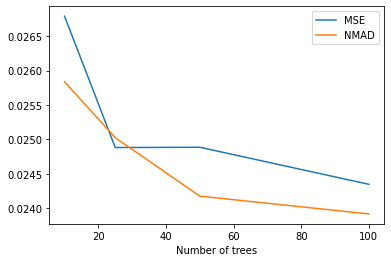

In [55]:
from sklearn.metrics import mean_squared_error,median_absolute_error
if 1:
    ntree_test = 10,25, 50,100
    mse=np.copy(ntree_test)*0.
    mad=np.copy(ntree_test)*0.

    for i,n in enumerate(ntree_test):
        # define the RF object with our choice of number of trees
        regrf = RandomForestRegressor(n_estimators = n, \
                                      max_depth = 30, max_features = 'auto')
        # do training AND prediction on the whole sample 
        #     using cross-validation
        predicted = cross_val_predict(regrf,data_colmag,data_z, cv=10)
        #calculate mean squared error
        mse[i]=mean_squared_error(data_z,predicted)
        #calculate MAD
        mad[i]=median_absolute_error(data_z,predicted)

    plt.plot(ntree_test, mse,label='MSE')
    plt.plot(ntree_test, mad,label='NMAD')
    plt.legend()
    plt.xlabel('Number of trees')

In [48]:
data_colmag.shape

(8508, 6)